# Was passiert mit openGLAM-Daten auf Wikidata?

*Alexander Winkler, <winkler@zib.de>, [ORCID 0000-0002-9145-7238](https://orcid.org/0000-0002-9145-7238)*

## Einleitung

Für GLAM-Institutionen bietet [Wikidata](https://www.wikidata.org) großes Potenzial, da sie ihre qualitativ hochwertigen Daten auf diese Weise einem breiten Publikum in maschinen- und menschenlesbarer sowie vielfach nachnutzbarer Form zugänglich machen können.
Die Daten werden eingebunden in den großen Wikidata-Wissensgraphen, werden direkt verlinkt oder aber indirekt in Verbindung gebracht mit anderen Objekten, mit weiteren Informationen angereichert und insgesamt besser auffindbar gemacht.

Zahlreiche Einrichtungen verwenden Wikidata auch als variabel erweiter- und editierbare Normdatei oder als Normdatenhub, auf dem verschiedene etablierte Normvokablare miteinander verknüpft werden.

Einen (etwas veralteten) Überblick über GLAM-Projekte mit Wikidata-Bezug bietet [diese Seite](https://www.wikidata.org/wiki/Wikidata:GLAM).

## Fragestellung

Diese oben behaupteten Vorteile sollten quantitativ untermauert werden, insbesondere um GLAM-Institutionen die Abwägung zu erleichtern, ob Ressourcen für die Bereitstellung ihrer Daten über Wikidata aufgewendet werden sollen.

Im Folgenden wird versucht, die Interaktion mit GLAM-Daten auf Wikidata in Zahlen zu fassen.
Zunächst soll untersucht werden, wie intensiv die Daten auf Wikidata bearbeitet werden.
Die Bearbeitungsintensität kann, so die These, als grober Indikator für die Wahrnehmung der Daten gelten.
Zudem ist davon auszugehen, dass durch die Bearbeitung die Datenqualität erhöht wird und somit die GLAM-Daten von ihrer Bereitstellung auf Wikidata profitieren.

## Methode

Die benötigten Informationen sind der Revisionsgeschichte der einzelnen Objekte zu entnehmen.
Über die Revisionsgeschichte gibt die [Mediawiki-API](https://www.mediawiki.org/wiki/API:Revisions) Aufschluss.

Die Liste relevanter Objekte, d.h. im konkreten Fall die Objekte einer Institutionen, ist mit einer SPARQL-Abfrage ermittelbar.

## Technische Präliminiarien

### Import benötigter Module

In [1]:
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import requests
import json
import re
from random import choices

### Tag-Liste für Bearbeitungsweisen von Wikidata laden

In der Revisionsgeschichte werden bestimmte [Tags](https://www.wikidata.org/wiki/Special:Tags) verwendet, um zu kennzeichnen, wie ein Bearbeitungvorgang der Seite stattfand. Durch den Tag `wikidata-ui` wird z.B. angezeigt, dass eine Bearbeitung über die GUI erfolgte.

Im Dictionary `WikidataTagsDict` werden für die spätere Visualisierung die aussagekräftigeren Bezeichnungen der Tags gesammelt.

In [2]:
html = requests.get("https://www.wikidata.org/wiki/Special:Tags").text
soup = BeautifulSoup(html)

WikidataTagsDict = {}

for row in soup.tbody.find_all('tr'):
    tag,appearance,descr,source,active,num = [_.text for _ in row.find_all("td")]
    WikidataTagsDict[tag] = appearance

### Labels für Properties

Die Datei `properties.json` enthält die Labels für häufig verwendete Properties.
Damit die Properties nicht immer von neuem geladen werden müssen, werden sie lokal gespeichert und ins Dictionary `PropertyDict` geladen.

In [3]:
# Einlesen eines Ergebnis-Dict aus Datei
with open('properties.json') as json_file:
    PropertyDict = json.load(json_file)

## Umsetzung

Als Beispiel sollen die Objekte der Berliner Gemäldegalerie ([Q165631](http://www.wikidata.org/entity/Q165631)) dienen.
Der entsprechende SPARQL-Query im Wikidata Query Service: <https://w.wiki/6t6V> .

Der Query (`query`) kann durch einen beliebigen anderen ersetzt werden.

In [4]:
# Ermittlung der Q-IDs


#pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Berliner Gemäldegalerie
query = """SELECT ?x WHERE {
  ?x wdt:P276 wd:Q165631 .
  }"""


def get_results(endpoint_url, query):
    '''
    Abruf der Ergebnisse einer SPARQL-Anfrage an den Wikidata-Endpoint
    '''
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

/home/alex/.local/lib/python3.9/site-packages/rdflib_jsonld/__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.0.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(


In [5]:
# Extraktion der Q-IDs
# Ergebnis: Eine Liste der Q-IDs, die der SPARQL-Query zurückgibt.
qidList = []
for result in results["results"]["bindings"]:
    uri = result.get('x').get('value')
    qid = uri.split("/")[-1]
    qidList.append(qid)

In [6]:
print(f"Anzahl der auf Wikidata ermittelten Objekte: {len(qidList)}")

Anzahl der auf Wikidata ermittelten Objekte: 3662


### Bezug der Revisionsgeschichte

In [391]:
def getRevisionHistory(qid):
    '''
    Fragt über die API die Revisionsgeschichte zu einer Q-ID ab.
    '''
    endpoint = "https://www.wikidata.org/w/api.php"
    params = {
        'action' : 'query',
        'prop' : 'revisions',
        'titles' : qid,
        'rvslots' : 'main',
        'rvlimit' : '500',
        'rvprop' : 'timestamp|user|comment|size|tags',
        'format' : 'json'
    }
    res = requests.get(endpoint, params = params)
    return res

In [392]:
resultDict = {}

#for obj in choices(qidList,k=50): # eine Auswahl zum Testen bei einer größeren Treffermenge
for obj in qidList:
    res = getRevisionHistory(obj)
    for x in res.json().get('query').get('pages').values():
        resultDict[x.get('title')] = x.get('revisions')

## Optional Sicherungskopien

Gerade bei größeren Treffermengen kann der Abruf, der für jede Q-ID einzeln erfolgt, Zeit brauchen.
Es bietet sich also an, die Ergebnisse lokal zu speichern.

Der Dateiname (`backupFileName`) kann geändert werden, damit unterschiedliche Datensätze gespeichert werden können.

In [7]:
backupFileName = "gemaeldegalerie.json"

In [393]:
#Schreibe Ergebnis-Dict in Datei
with open(backupFileName, "w") as OUT:
    OUT.write(json.dumps(resultDict))

In [8]:
# Einlesen eines Ergebnis-Dict aus Datei
with open(backupFileName, "r") as json_file:
    resultDict = json.load(json_file)

## Frage: Wie viele unterschiedliche User:innen haben über das Web-Interface Objekte der Gemäldegalerie bearbeitet?

Nun wird ein Blick auf die Revisionsgeschichte geworfen.
Dabei sollen zunächst nur Edits über die Wikidata-Weboberfläche berücksichtigt werden, d.h. solche, die vermutlich manuell vorgenommen wurden.
Diese Edits enthalten den Tag `wikidata-ui`.

In [9]:
manuallyChangedItems = dict()
manuallyChangedProps = dict()

for qid,rev in resultDict.items():
    manuallyChangedItems[qid] = []
    manuallyChangedProps[qid] = []
    for r in rev:
        user = r.get('user')
        time = r.get('timestamp')
        comm = r.get('comment')
        tags = r.get('tags')
        m = re.match(r'\/\* (?P<action>\S+):\d\|\|\d \*\/ \[\[Property:(?P<prop>\w+)\]\]:' , comm)        
        if "wikidata-ui" in tags:
            manuallyChangedItems[qid].append(user)
            if m:
                manuallyChangedProps[qid].append(m.groupdict().get('prop'))

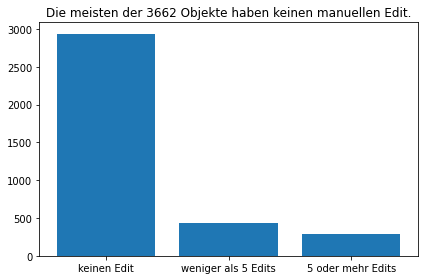

In [10]:
categories = []
for k,v in manuallyChangedItems.items():
    if len(v) == 0:
        categories.append("keinen Edit")
    if 0 < len(v) < 5:
        categories.append("weniger als 5 Edits")
    if 4 < len(v):
        categories.append("5 oder mehr Edits")

c = Counter(categories)
xlabels = ["keinen Edit", "weniger als 5 Edits", "5 oder mehr Edits"]
plt.bar(xlabels, [c.get(_) for _ in xlabels])
title = f"Die meisten der {len(manuallyChangedItems)} Objekte haben keinen manuellen Edit."
plt.title(title)
plt.tight_layout()

In [462]:
anteil = (c.get('5 oder mehr Edits') + c.get('weniger als 5 Edits')) / sum(c.values())

print(f"Der Anteil von manuell bearbeiteten Objekten beträgt {anteil * 100:.0f} %.")

Der Anteil von manuell bearbeiteten Objekten beträgt 20 %.


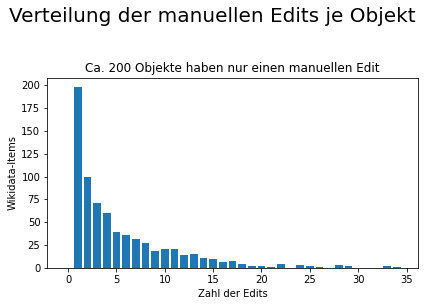

In [463]:
c = Counter([len(v) for v in manuallyChangedItems.values() if len(v) > 0])
xs = range(len(c))
ys = [c.get(x,0) for x in xs]
plt.bar(xs,ys)
plt.suptitle("Verteilung der manuellen Edits je Objekt", y=1.05, fontsize=20)
plt.title("Ca. 200 Objekte haben nur einen manuellen Edit")
plt.ylabel("Wikidata-Items")
plt.xlabel("Zahl der Edits")
plt.tight_layout()

### User:innen

Welche User:innen haben die Edits über die Weboberfläche vorgenommen?

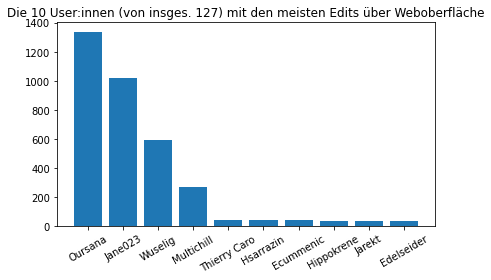

In [464]:
users = []
for _ in manuallyChangedItems.values():
    users.extend(_)

n = 10
xs,ys = zip(*Counter(users).most_common(n))
plt.bar(xs,ys)
plt.xticks(rotation=30)
title = f"Die {n} User:innen (von insges. {len(set(users))}) mit den meisten Edits über Weboberfläche"
plt.title(title)
plt.tight_layout()

### Welche Properties werden bearbeitet?

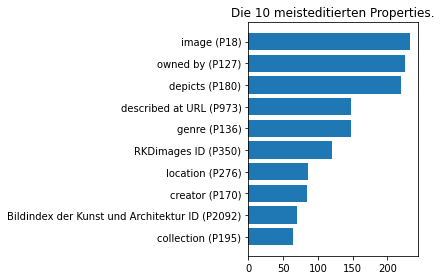

In [465]:
props = []
for v in manuallyChangedProps.values():
    props.extend(v)
    
## Nötigenfalls Properties ins PropertyDict nachladen ...
for p in Counter(props).keys():
    if not p in PropertyDict:
        res = requests.get(f"https://www.wikidata.org/wiki/Special:EntityData/{p}.json")
        label = res.json().get('entities').get(p).get('labels').get('en').get('value')
        PropertyDict[p] = label
    
## ... und wieder speichern
with open("properties.json", "w") as OUT:
    OUT.write(json.dumps(PropertyDict))   
    
xs = []
ys = []

n = 10
for _ in Counter(props).most_common(n):
    xs.append(f"{PropertyDict.get(_[0])} ({_[0]})")
    ys.append(_[1])


title = f"Die {n} meisteditierten Properties."
plt.barh(xs,ys)
plt.gca().invert_yaxis() # https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down

plt.title(title)
plt.tight_layout()
plt.show()

## Verlinkungen auf Seite

Als nächster möglicher Schritt ließen sich die Links, die zu den Objektseiten führen, analysieren.

Der entsprechende API-Eintrag zu [`linkshere`](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Blinkshere).
`linkshere` liefert alle Wikimedia-Seiten, die auf die Seite (nicht das Item) verweisen

In [466]:
# Beispielabfrage für ein Item

res = requests.get("https://www.wikidata.org/w/api.php?action=query&prop=linkshere&titles=Q47517445&format=json")
res.json()

{'batchcomplete': '',
 'query': {'pages': {'48560678': {'pageid': 48560678,
    'ns': 0,
    'title': 'Q47517445',
    'linkshere': [{'pageid': 43590427,
      'ns': 4,
      'title': 'Wikidata:WikiProject sum of all paintings/Collection/Berlinische Galerie'},
     {'pageid': 55799717,
      'ns': 4,
      'title': 'Wikidata:WikiProject sum of all paintings/Creator/Issai Kulvianski'}]}}}}

Ergänzend hierzu ließe sich über den SPARQL-Endpoint ermitteln, welche anderen Wikidata-Items die Objekte der GLAM-Einrichtungen 

## Fazit

Zumindest die oberflächliche  Betrachtung legt nahe, dass die Wikidata-Community bei einem gewissen Teil (hier 20%) die Daten manuell nachbearbeitet und damit wohl auch ihre Qualität steigert oder sie mit Informationen anreichert, die womöglich in den Datenbanken der Institutionen nicht (explizit) enthalten sind (Inhaltsbeschreibung, Normvokabulare etc.)

## Ausblick

Die oben vorgestellte 'Probebohrung' müsste erheblich verfeinert werden.

Es könnte z.B. noch untersucht werden, welchen Einfluss die Aufnahme von Objekten in bestimmte Kategorien oder Projekte (z.B. [Sum of all Paintings](https://www.wikidata.org/wiki/Wikidata:WikiProject_sum_of_all_paintings)) hat, ob und wenn ja welche Personencluster sich unter den Editor:innen herausbilden, welche Interessensschwerpunkte sie haben, wann die Edits im Datenlebenszyklus erfolgen etc.

Hinweise, Fragen und Anregungen gerne jederzeit an <winkler@zib.de> oder auch auf [Mastodon](https://openbiblio.social/@awinkler).

<p xmlns:dct="http://purl.org/dc/terms/" xmlns:vcard="http://www.w3.org/2001/vcard-rdf/3.0#">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <a rel="dct:publisher"
     href="https://orcid.org/0000-0002-9145-7238">
    <span property="dct:title">Alexander Winkler</span></a>
  has waived all copyright and related or neighboring rights to
  <span property="dct:title">Was passiert mit openGLAM-Daten auf Wikidata?</span>.
This work is published from:
<span property="vcard:Country" datatype="dct:ISO3166"
      content="DE" about="https://orcid.org/0000-0002-9145-7238">
  Germany</span>.
</p>